In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
from scipy.stats import combine_pvalues
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from os.path import join
import glob
from sklearn.cluster import SpectralCoclustering
from scipy.stats import pearsonr, spearmanr

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md
from anndata import read_h5ad

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# logging
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.2 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 leidenalg==0.8.2


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
GS_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs'

Trying to set attribute `.obs` of view, copying.


In [3]:
# SCORE_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.tms_facs.gwas_max_abs_z.top500'
# SCORE_PATH = "/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.tms_facs_with_cov.gwas_max_abs_z.top500.030121"
SCORE_PATH = "/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.tms_facs_with_cov.gwas_max_abs_z.top500"

trait_list = []
df_list = []
for file in [x for x in os.listdir(SCORE_PATH) if '.score.gz' in x]:
    trait = file.replace('.score.gz','')
    trait_list.append(trait)
    temp_df = pd.read_csv(join(SCORE_PATH,file), sep='\t', index_col=0)
    temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
    temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
    df_list.append(temp_df)
df_trs_score = pd.concat(df_list, axis=1)
trait_list = sorted(list(set(trait_list)))

In [4]:
def pval2zsc(pval):
    import scipy
    return -scipy.stats.norm.ppf(pval)

In [5]:
def agg_trs_results(df_obs, df_score, trait_list, stats, groupby="tissue_celltype"):
    """
    Extract TRS results
    df_obs: from AnnData.obs
    df_score: cell-specific score
    trait_list: list of traits
    groupby: aggregate by either tissue_celltype or cell_ontology_class
    """
    assert stats in ["pval", "mean", "sd", "fdr"]
    assert groupby in ["tissue_celltype"]
    # extract pval or fdr
    if stats == "fdr":
        df_obs = df_obs.join(df_score[[x for x in df_score.columns if x.split('.')[-1] == "fdr"]])
    else:
        df_obs = df_obs.join(df_score[[x for x in df_score.columns if x.split('.')[-1] == "pval"]])
    
    # filter groups with small number of cells
    temp_df = df_obs.groupby(groupby).agg({'cell':len})
    temp_key_list = temp_df.index[temp_df['cell']>100]
    
    if stats == "pval":
        temp_df = df_obs.groupby(groupby).agg({'%s.pval'%x : lambda a : np.maximum(-np.log10(len(a) * np.min(a)), 0.) for x in trait_list})
    elif stats == "mean":
        temp_df = df_obs.groupby(groupby).agg({'%s.pval'%x : lambda a : np.mean(-np.log10(a)) for x in trait_list})
    elif stats == "sd":
        temp_df = df_obs.groupby(groupby).agg({'%s.pval'%x : lambda a : np.std(-np.log10(a)) for x in trait_list})
    elif stats == "fdr":
        temp_df = df_obs.groupby(groupby).agg({'%s.fdr'%x : lambda a : np.mean(a < 0.1) for x in trait_list})
        
    else:
        raise NotImplementedError
    
    temp_df = temp_df.loc[temp_key_list]
    if stats == "fdr":
        temp_df.columns = [x.replace(f'.fdr','') for x in temp_df.columns]
    else:
        temp_df.columns = [x.replace(f'.pval','') for x in temp_df.columns]
    trs_df = temp_df.T.copy()
    trs_df.columns = [c.replace(" ", "_").replace(",", "") for c in trs_df.columns]
    return trs_df    

In [6]:
trs_pval_df = agg_trs_results(df_obs=data_facs_ct.obs.copy(), df_score=df_trs_score, trait_list=trait_list, stats="pval")
trs_mean_df = agg_trs_results(df_obs=data_facs_ct.obs.copy(), df_score=df_trs_score, trait_list=trait_list, stats="mean")
trs_sd_df = agg_trs_results(df_obs=data_facs_ct.obs.copy(), df_score=df_trs_score, trait_list=trait_list, stats="sd")
trs_fdr_df = agg_trs_results(df_obs=data_facs_ct.obs.copy(), df_score=df_trs_score, trait_list=trait_list, stats="fdr")

ldsc_result_dir = "/n/home12/khou/scTRS/experiments/job.ldsc_seg/"
# top 500 genes
ldsc_pval_df = pd.DataFrame(index=trs_pval_df.index, columns=trs_pval_df.columns)
for trait in trs_pval_df.index:
    rls = pd.read_csv(join(ldsc_result_dir, f"out/cts_result/{trait}.cell_type_results.txt"), sep='\t')
    ldsc_pval_df.loc[trait, :] = -np.log10(rls.set_index("Name").loc[ldsc_pval_df.columns, "Coefficient_P_value"])
ldsc_pval_df = ldsc_pval_df.astype(float)

In [7]:
immune_traits = [
    "UKB_460K.disease_ASTHMA_DIAGNOSED",
    "PASS_Celiac",
    "PASS_Crohns_Disease",
    "UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED",
    "PASS_IBD_deLange2017",
    "PASS_Lupus",
    "PASS_Multiple_sclerosis",
    "PASS_Primary_biliary_cirrhosis",
    "PASS_Rheumatoid_Arthritis",
    "PASS_Type_1_Diabetes",
    "PASS_Ulcerative_Colitis",
]

brain_traits = [
    "PASS_Alzheimers_Jansen2019",
    "PASS_ADHD_Demontis2018",
    "PASS_Anorexia",
    "PASS_Autism",
    "PASS_BipolarDisorder_Ruderfer2018",
    "PASS_Schizophrenia_Ruderfer2018",
    "UKB_460K.body_BMIz",
    "PASS_Depression_Nagel2018",
    "PASS_DepressedAffect_Nagel2018",
    "UKB_460K.mental_NEUROTICISM",
    "UKB_460K.cov_SMOKING_STATUS",
    "UKB_460K.cov_EDU_YEARS",
]

metabolic_traits = [
    "PASS_FastingGlucose_Manning",
    "PASS_HDL",
    "PASS_LDL",
    "PASS_Triglycerides",
    'UKB_460K.bp_DIASTOLICadjMEDz',
    'UKB_460K.bp_SYSTOLICadjMEDz',
    "UKB_460K.body_WHRadjBMIz",
    "PASS_Coronary_Artery_Disease",
    "UKB_460K.disease_HYPERTENSION_DIAGNOSED",
    "PASS_Type_2_Diabetes",
    "PASS_IschemicStroke_Malik2018",
    'UKB_460K.lung_FEV1FVCzSMOKE',
    'UKB_460K.lung_FVCzSMOKE',
    "UKB_460K.body_HEIGHTz",
    "UKB_460K.bmd_HEEL_TSCOREz"
]

trait_list = immune_traits + brain_traits + metabolic_traits
# trait_list = ldsc_pval_df.index.tolist()

In [8]:
subset_ldsc_pval_df = pd.DataFrame(ldsc_pval_df.loc[trait_list, :]).reset_index().melt('index')
subset_ldsc_pval_df.columns = ["trait", "ct", "nlog10p"]

subset_trs_pval_df = pd.DataFrame(trs_pval_df.loc[trait_list, :]).reset_index().melt('index')
subset_trs_pval_df.columns = ["trait", "ct", "nlog10p"]

subset_trs_mean_df = pd.DataFrame(trs_mean_df.loc[trait_list, :]).reset_index().melt('index')
subset_trs_sd_df = pd.DataFrame(trs_sd_df.loc[trait_list, :]).reset_index().melt('index')
subset_trs_fdr_df = pd.DataFrame(trs_fdr_df.loc[trait_list, :]).reset_index().melt('index')

plot_df = pd.merge(subset_ldsc_pval_df, subset_trs_pval_df, on=["trait", "ct"], suffixes=["_ldsc", "_trs"])
plot_df["trs_mean"] = subset_trs_mean_df["value"]
plot_df["trs_sd"] = subset_trs_sd_df["value"]
# proportion of FDR < 0.1
plot_df["trs_fdr_prop"] = subset_trs_fdr_df["value"]

Number of TRS significant celltype-trait pairs 290
Number of LDSC-SEG significant celltype-trait pairs 277


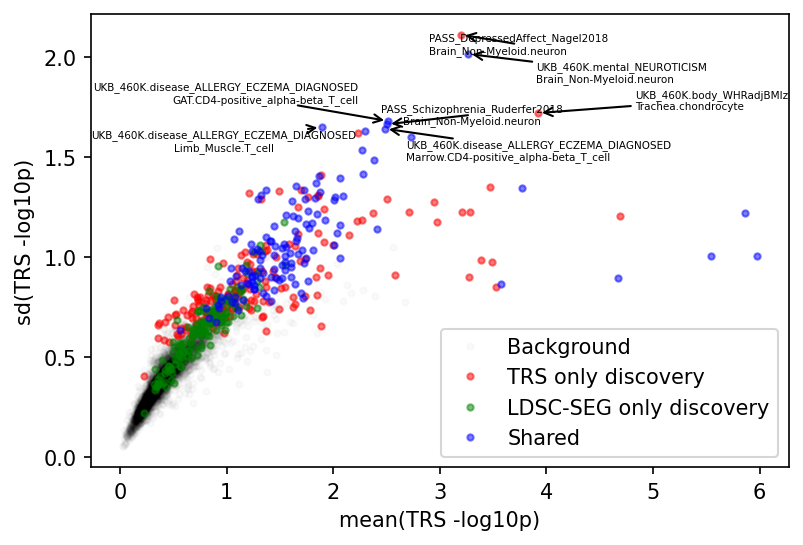

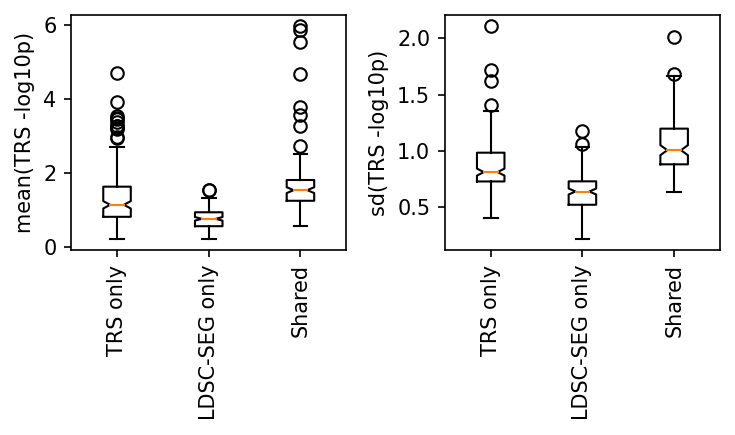

In [9]:
from adjustText import adjust_text
# adjust the FDR prop, such that the overall #discoveries are similar
trs_signif_index = plot_df.trs_fdr_prop > 0.01
# trs_signif_index = plot_df.nlog10p_trs > 3
ldsc_signif_index = multipletests(np.power(10, -plot_df.nlog10p_ldsc), alpha=0.05, method="fdr_bh")[0]

print("Number of TRS significant celltype-trait pairs", sum(trs_signif_index))
print("Number of LDSC-SEG significant celltype-trait pairs", sum(ldsc_signif_index))


plt.figure(dpi=150, figsize=(6, 4))
plt.plot(plot_df.trs_mean, plot_df.trs_sd, 'k.', alpha=0.02, label="Background")

# TRS only
trs_only_index = trs_signif_index & (~ldsc_signif_index)
ldsc_only_index = (~trs_signif_index) & ldsc_signif_index
shared_index = trs_signif_index & ldsc_signif_index

plt.plot(plot_df.trs_mean[trs_only_index], 
         plot_df.trs_sd[trs_only_index], 
         'r.', label="TRS only discovery", alpha=0.5)

plt.plot(plot_df.trs_mean[ldsc_only_index], 
         plot_df.trs_sd[ldsc_only_index], 
         'g.', label="LDSC-SEG only discovery", alpha=0.5)

plt.plot(plot_df.trs_mean[shared_index], 
         plot_df.trs_sd[shared_index], 
         'b.', label="Shared", alpha=0.5)

annot_df = plot_df.sort_values("trs_sd", ascending=False).iloc[0: 7]

ts = []
ts_x = []
ts_y = []
for _, row in annot_df.iterrows():
    ts_x.append(row.trs_mean)
    ts_y.append(row.trs_sd)
    ts.append(plt.text(row.trs_mean, row.trs_sd, f"{row.trait}\n{row.ct}", fontsize=5))
adjust_text(ts, x=ts_x, y=ts_y, force_points=0.1, arrowprops=dict(arrowstyle='->', color='black'))

plt.legend(loc='lower right')
plt.xlabel("mean(TRS -log10p)")
plt.ylabel("sd(TRS -log10p)")
plt.show()

# ========================================================================
fig, axes = plt.subplots(ncols=2, dpi=150, figsize=(5, 3))
axes[0].boxplot([plot_df.trs_mean[trs_only_index], plot_df.trs_mean[ldsc_only_index], plot_df.trs_mean[shared_index]], notch=True)
axes[0].set_xticklabels(["TRS only", "LDSC-SEG only", "Shared"], rotation=90)
axes[0].set_ylabel("mean(TRS -log10p)")

axes[1].boxplot([plot_df.trs_sd[trs_only_index], plot_df.trs_sd[ldsc_only_index].dropna(), plot_df.trs_sd[shared_index]], notch=True)
axes[1].set_xticklabels(["TRS only", "LDSC-SEG only", "Shared"], rotation=90)
axes[1].set_ylabel("sd(TRS -log10p)")
plt.tight_layout()
plt.show()

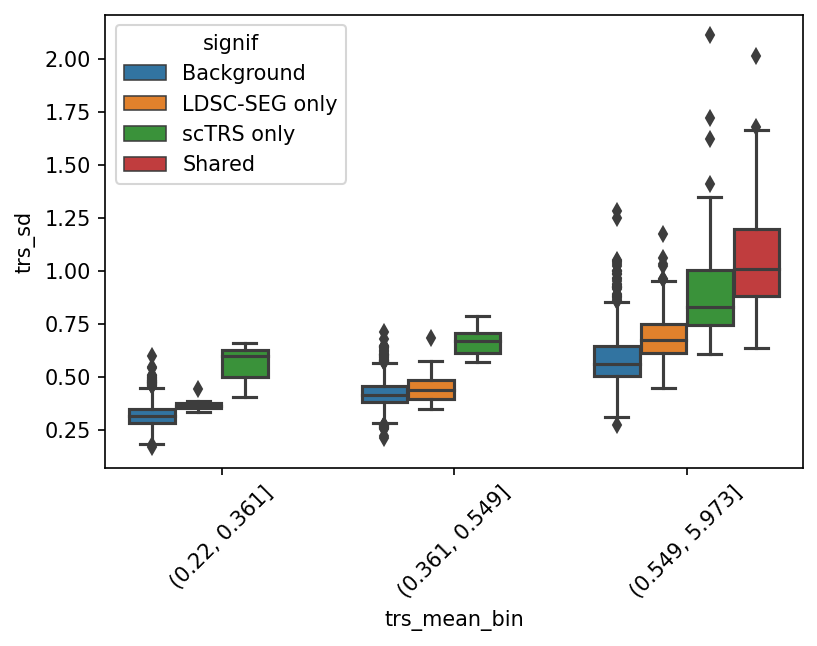

In [10]:
boxplot_df = plot_df[plot_df.trs_mean > plot_df.trs_mean[trs_signif_index | ldsc_signif_index].min()].copy()
n_bin = 3
boxplot_df["trs_mean_bin"] = pd.qcut(boxplot_df['trs_mean'], q=n_bin)
boxplot_df["signif"] = "Background"
boxplot_df.loc[trs_signif_index & ldsc_signif_index, "signif"] = "Shared"
boxplot_df.loc[trs_signif_index & (~ldsc_signif_index), "signif"] = "scTRS only"
boxplot_df.loc[(~trs_signif_index) & ldsc_signif_index, "signif"] = "LDSC-SEG only"

plt.figure(dpi=150)
p = sns.boxplot(x="trs_mean_bin", y="trs_sd",
            hue="signif", data=boxplot_df)
p.set_xticklabels(p.get_xticklabels(), rotation=45)
plt.show()

# Overall consistency between scTRS and LDSC-SEG

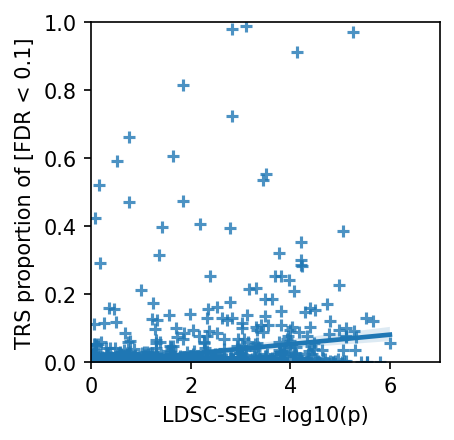

(0.282123105008357, 7.371196710575241e-96)


In [11]:
# plt.figure(dpi=150, figsize=(3, 3))
# sns.regplot(plot_df.nlog10p_ldsc, plot_df.nlog10p_trs, marker="+")
# # plt.plot(plot_df.nlog10p_ldsc, plot_df.nlog10p_trs, 'b.', alpha=0.2)
# plt.xlabel("LDSC-SEG -log10(p)")
# plt.ylabel("TRS aggregated -log10(p)")
# plt.xlim(0, 7)
# plt.ylim(0, 7)
# plt.show()
# print(pearsonr(plot_df.nlog10p_ldsc, plot_df.nlog10p_trs))

plt.figure(dpi=150, figsize=(3, 3))
sns.regplot(plot_df.nlog10p_ldsc, plot_df.trs_fdr_prop, marker="+")
# plt.plot(plot_df.nlog10p_ldsc, plot_df.trs_fdr_prop, 'b.', alpha=0.2)
plt.xlabel("LDSC-SEG -log10(p)")
plt.ylabel("TRS proportion of [FDR < 0.1]")
plt.xlim(0, 7)
plt.ylim(0, 1)
plt.show()
print(pearsonr(plot_df.nlog10p_ldsc, plot_df.trs_fdr_prop))

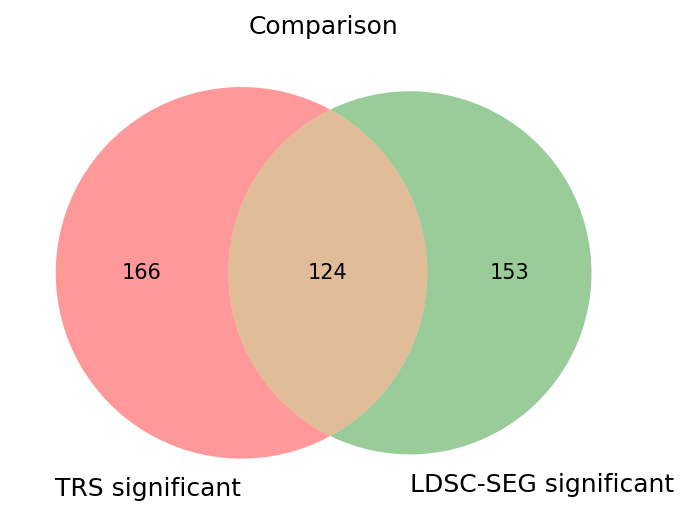

(23.254271989920465, 6.401016361849589e-90)


In [12]:
from matplotlib_venn import venn2, venn2_circles
from scipy.stats import fisher_exact

plt.figure(dpi=150)
trs_signif_index = np.where(trs_signif_index)[0]
ldsc_signif_index = np.where(ldsc_signif_index)[0]

venn2([set(trs_signif_index), set(ldsc_signif_index)], set_labels = ('TRS significant', 'LDSC-SEG significant'))
plt.title('Comparison')
plt.show()

contingency_tbl = np.zeros((2,2))

contingency_tbl[1, 0] = len(set(ldsc_signif_index) - set(trs_signif_index))
contingency_tbl[0, 1] = len(set(trs_signif_index) - set(ldsc_signif_index))
contingency_tbl[1, 1] = len(set(trs_signif_index) & set(ldsc_signif_index))
contingency_tbl[0, 0] = plot_df.shape[0] - contingency_tbl[1, 0] - contingency_tbl[0, 1] - contingency_tbl[1, 1]

print(fisher_exact(contingency_tbl))